<a href="https://colab.research.google.com/github/ENGCSS/Trabalho_Analise_espacial_de_redes/blob/main/Tb_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# INSTALA AS BIBLIOTECAS NECESSÁRIAS
!pip install osmnx -q                                                         # Instala a biblioteca OSMnx para análise de redes viárias e geodados
!pip install geopandas folium matplotlib fiona -q                                   # Instala as bibliotecas GeoPandas, Folium e Matplotlib
!pip install mapclassify -q                                                   # Instala o Mapclassify para classificação de dados espaciais

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.7 MB/s eta 0:00:00


In [5]:
# IMPORTA AS BIBLIOTECAS NECESSÁRIAS
import osmnx as ox                                                            # Biblioteca para análise de redes viárias e geodados
import folium                                                                 # Biblioteca para criar mapas interativos
import matplotlib.pyplot as plt                                               # Biblioteca para plotagens gráficas
import geopandas as gpd                                                       # Biblioteca para manipulação de dados geoespaciais
import fiona                                                                  # Biblioteca para manipulação de dados geoespaciais
import warnings                                                               # Biblioteca para gerenciar avisos no Python
warnings.filterwarnings("ignore")                                             # Ignorar avisos para manter o console limpo

In [1]:
!git clone https://github.com/ENGCSS/Trabalho_Analise_espacial_de_redes.git

Cloning into 'Trabalho_Analise_espacial_de_redes'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21 (delta 6), reused 14 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 509.48 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [8]:
# Caminho para o arquivo GeoPackage
geopackage_path = '/content/Trabalho_Analise_espacial_de_redes/DATA/DADOS.gpkg'

# Ler a camada específica do GeoPackage
gdf_pontos = gpd.read_file(geopackage_path,
                           layer='eq_rs_irece'
                           )

gdf_regiao = gpd.read_file(geopackage_path,
                           layer='rs_irece'
                           )

gdf_irece = gpd.GeoDataFrame(gdf_regiao[gdf_regiao["nome_mun"] == "Irecê"],
                             crs=gdf_regiao.crs
                             )

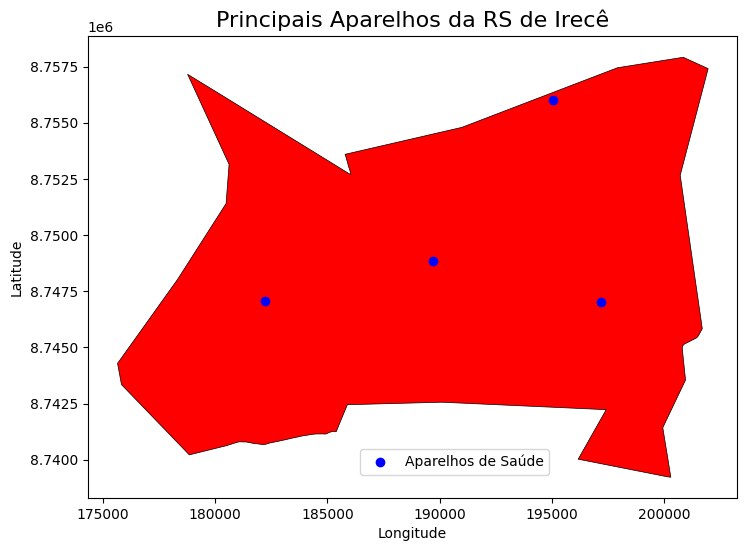

In [44]:
# CRIAÇÃO DA FIGURA E DOS EIXOS
fig, ax = plt.subplots(figsize=(10, 6))

# PLOTAGEM DO PRIMEIRO GDF
# DEFININDO COR E LEGENDA
gdf_irece.plot(ax=ax,
                color="red",
                alpha=1,
                edgecolor="black",
                linewidth=0.5,
                label="Região de Saúde de Irecê"
                )

# PLOTAGEM DO SEGUNDO GDF
# DEFININDO COR E LEGENDA
gdf_pontos.plot(ax=ax,
                color="blue",
                label="Aparelhos de Saúde"
                )

# CONFIGURAÇÃO DE TÍTULOS E LEGENDA
plt.title("Principais Aparelhos da RS de Irecê", fontsize=16)                   # TÍTULO DO GRÁFICO
plt.xlabel("Longitude")                                                         # RÓTULO DO EIXO X
plt.ylabel("Latitude")                                                          # RÓTULO DO EIXO Y
plt.legend(loc=(0.42,0.05))                                                     # ADICIONA A LEGENDA AO GRÁFICO

# EXIBIÇÃO DO MAPA
plt.show()

<Axes: >

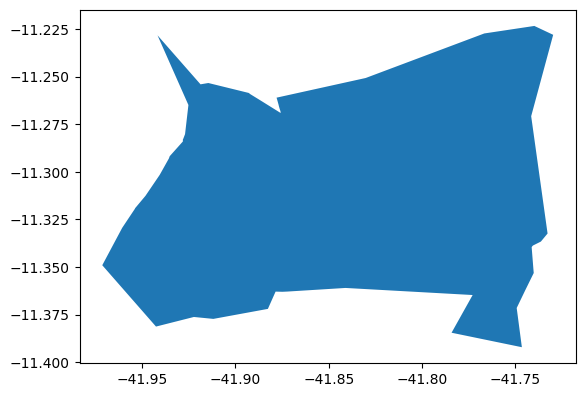

In [46]:
# DEFINI DA CIDADE
cidade = "Irecê, Brasil"                                                        # Define o nome da cidade para ser usado na extração de dados geográficos

# OBTER O POLÍGONO DA CIDADE
poligono_cidade = ox.geocode_to_gdf(cidade)                                     # Realiza a geocodificação para obter o polígono da cidade

# CALCULAR O CENTRO DO POLÍGONO
centro = [poligono_cidade.geometry.centroid.y.values[0],                        # Coordenada Y do centroide
          poligono_cidade.geometry.centroid.x.values[0]]                        # Coordenada X do centroide

# PLOTAR O POLÍGONO DA CIDADE
poligono_cidade.plot()

In [75]:
# Carregar o geodataframe de pontos
pts = gdf_pontos.to_crs(epsg=4326)

# MAPA CENTRALIZADO NO BAIRRO
mapa_01 = folium.Map(location=centro,                                           # Define o centro do mapa
                     zoom_start=12,                                             # Define o nível inicial de zoom
                     tiles='CartoDB positron'                                   # Define o tipo de mapa de fundo
                     )

geo_json = poligono_cidade.to_json()                                            # Converte o polígono do bairro para o formato GeoJSON

# ADICIONA O POLÍGONO DA ÁREA AO MAPA
folium.GeoJson(geo_json,                                                        # Adiciona o polígono representando a área do bairro
               name="CentroNit",                                                # Nome da camada no controle
               style_function=lambda x: {'fillColor': 'MediumSpringGreen',      # Cor de preenchimento
                                         'color': 'purple',                     # Cor da borda
                                         'weight': 2.5,                         # Espessura da borda
                                         'fillOpacity': 0.3                     # Opacidade do preenchimento
                                         }
               ).add_to(mapa_01)


# ADICIONAR PARADAS DE ÔNIBUS AO MAPA
for idx, row in pts.iterrows():

    #Carrega a imagem que será usada no popup do marcador
    with open(dir_imagem, "rb") as imagem_arquivo:
        imagem_codificada = base64.b64encode(imagem_arquivo.read()).decode('utf-8')

    #Cria o cod. html com o conteúdo do popup
    html_popup = f"""
    <!DOCTYPE html>
    <html lang="pt-BR">
    <head>
        <meta charset="UTF-8">
        <title>Detalhes do Ponto de Saúde</title>
    </head>
    <body>
        <h4><b>{row['NM_PT']}</b></h4>
        <p><b>{row['CAT']}</b></p>
        <img src="data:image/jpg;base64,{imagem_codificada}" alt="Imagem do Ponto de Saúde" style="max-width:300px;">
        <p>Serviços: {row['SERV']}</p>
    </body>
    </html>
    """
    #Cria o marcador do ponto
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],
        popup=folium.Popup(html_popup, max_width=450),
        tooltip=row['NM_PT'],
        icon=folium.Icon(color=row['COR'],
                         icon_color='k',
                         icon=row['ICO'],
                         prefix='fa'
                         ),
        draggable=True
    ).add_to(mapa_01)

# EXIBIR MAPA
mapa_01                                                                         # Renderiza o mapa interativo com o polígono da área

NameError: name 'dir_imagem' is not defined